# Data to Dome Workshop: Visualizing astronomical catelogs in various space engines

### Python

Python is rapidly becomming the defacto astronomical programming language, supported by an active community of tool builders. Python's capabilities are extended through packages, and there are a number of good ones for dealing with astronomical data. This tutorial uses astropy which contains core astronomical functions and astroquery which lets you access astronomical databases from within the python environment. We also give an example of using the pyWWT package to directly interact with Worldwide Telescope.

One of the challenges of working in python has always been installing all the packages needed to do your work. That has gotten much easier recently through some excellent package managers. If you are just starting out with python I strongly recommend using the Anaconda distribution from Continuum Analytics. Anaconda installs most of the packages needed for scientific computing with python (astropy is included with Anaconda, unfortunately you have to install astroquery and pyWWT yourself).


### Let's get started - Step #1 Acquiring the GAMA Data from the database

We will use the Galaxy and Mass Assembly survey as our example dataset. The nice thing about this survey is that MANY physical parameters are measured. We want to get our galaxy catalog from the GAMA survey, to do that we need to query its database. A survey database typically contains several different tables each measuring a number of different quantities. Looking at the structure of the GAMA database (its schema) I see that the quantities I are in two tables, the EMLines table has the coordinates we need to locate objects in 3D, these are sky position (RA and dec) and the redshift(z) which we will use to calculate the distance to the galaxy. That table also contains a measurement of the star formation rate (SFR) and a classification of emmission line galaxies (Emline_Class). There is another table called StellarMasses which has several interesting parameters, we will get  the mass of the galaxy (logmstar), its instrinsic brightness (absMag_r), its age (logage), mass to light ratio (logMoverM_i) and its metalicity (metal).

The database can be accessed using the Structured Query Language(SQL). SQL has a SELECT/FROM/WHERE format, after SELECT you list what parameters you want to pull from the dataase, after WHERE you specifiy which database tables they are located in, and after WHERE you can place conditions on which objects you wish to get back.

So our query will be:

    SELECT  EmLinesPhys.ra, EmLinesPhys.dec, EmLinesPhys.Z_TONRY,
            EmLinesPhys.SFR,EmLinesPhys.EMline_Class,
            StellarMasses.logmstar, StellarMasses.metal,
            StellarMasses.absMag_r,
            StellarMasses.logage, StellarMasses.logMoverl_i  
    FROM    EmLinesPhys JOIN StellarMasses ON 
            EmLinesPhys.CATAID = StellarMasses.CATAID  
    WHERE   EmLinesPhys.NQ>2  

The purpose of the JOIN syntax in the FROM clause is to make sure we are looking at the same galaxies in each table. The conditions in the WHERE clause make sure that the galaxies spectrum was high quality and that the redshift was certain.

Using the <a href="http://astroquery.readthedocs.org/en/latest/#">astroquery module</a> we can query the GAMA database inside python and return the results in a data table.

In [5]:
from astroquery.gama import GAMA
from astropy.table import Table,Column
from astropy import units as u
from astropy.coordinates import ICRS, CartesianRepresentation, SkyCoord, Distance
#Acquire Data from GAMA database
galaxyTable = GAMA.query_sql('''SELECT  EmLinesPhys.ra, EmLinesPhys.dec, EmLinesPhys.Z_TONRY,
    EmLinesPhys.SFR,EmLinesPhys.EMline_Class,
    StellarMasses.logmstar, StellarMasses.metal, StellarMasses.absMag_r,
    StellarMasses.logage, StellarMasses.logMoverl_i
FROM EmLinesPhys JOIN StellarMasses ON EmLinesPhys.CATAID = StellarMasses.CATAID
WHERE EmLinesPhys.NQ>2
''')

ERROR:root:An unexpected error occurred while tokenizing input
The following traceback may be corrupted or invalid
The error message is: ('EOF in multi-line string', (1, 0))



TimeoutError: Query timed out, time elapsed 3.0s

In [3]:
galaxyTable

ra,DEC,Z_TONRY,SFR,EMline_Class,logmstar,metal,absMag_r,logage,logMoverl_i
float64,float64,float64,float64,str3,float64,float64,float64,float64,float64
174.005983764,0.720927127591,0.0518138,0.185113,SF,9.12851042187,0.0330536359134,-18.1912828065,9.71615145135,1.70443138463
174.022806365,0.705937411068,0.332804,9.36947,XXX,11.0503601715,0.0202665491508,-22.8990099392,9.5188614887,1.71930527053
174.100729377,0.658914274054,0.231281,0.337188,XXX,10.847068929,0.0184374417908,-21.7511866961,9.83104106697,1.97362202031
174.153156272,0.815426501273,0.00443048,0.991787,SF,7.48716971791,0.000835064700905,-15.5538521806,8.98493833937,1.24984356073
174.280512612,0.70608150666,0.11532,0.297587,XXX,9.55955138127,0.0130184432258,-19.7482673646,9.54962088239,1.54259491999
174.302786008,0.789984596388,0.0755416,1.12436,SF,9.82172906009,0.0066186863944,-20.0559795935,9.77329420201,1.68111562156
174.305547692,0.790335098179,0.075832,0.146217,SF,9.47458337058,0.00753276230635,-19.4336258665,9.53293449679,1.57845309087
174.335362931,0.83656295513,0.108041,0.921479,SF,9.85374077052,0.0148749711966,-20.1791723545,9.64901273283,1.64606476136
174.346901089,0.696450160048,0.194536,5.50625,SF,10.7435902879,0.0116710343688,-21.785559543,9.75131790244,1.87585864721


In [ ]:
# Write Table to file
from astropy.io import ascii
ascii.write(galaxyTable,'data/GAMA.dat')

In [ ]:
# Read table from file
galaxyTable=ascii.read('data/GAMA.dat')

## Plotting the Data
Let's see what we got back. Here I am using the plotting packages matplotlib and Seaborn (the latter to make things pretty, but the plots will work without it, just remove the import)

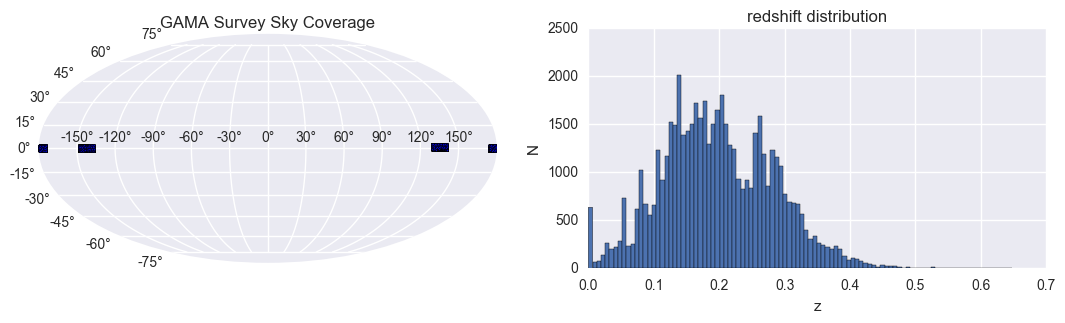

In [2]:
%config InlineBackend.rc = {}
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn
import numpy as np
from astropy.coordinates import Angle
fig = plt.figure (figsize=(13,3))
ax = fig.add_subplot(121,projection="mollweide")
ax.grid(True)
ax.set_title("GAMA Survey Sky Coverage")
ax.scatter(Angle(galaxyTable['ra'],u.deg).wrap_at(180.*u.deg).radian,Angle(galaxyTable['DEC'],u.deg).radian,s=1)
a2 = fig.add_subplot(122)
a2.hist(galaxyTable['Z_TONRY'],bins=100)
a2.set_title("redshift distribution")
a2.set_xlabel("z")
a2.set_ylabel("N")

### Step #2 Calculate distance to the galaxies from their redshift

Now to calculate the comoving distance we'll need to choose a set of Cosmological parameters. One of the really nice features of astropy is  the built in set of standard cosmologies. Here I choose the Planck15 cosmology defined <a href="http://arxiv.org/abs/1303.5076">here</a>.

In [4]:
from astropy.cosmology import Planck15
Planck15,Planck15.comoving_distance(0.4), Planck15.age(0.4)

(FlatLambdaCDM(name="Planck15", H0=67.7 km / (Mpc s), Om0=0.307, Tcmb0=2.725 K, Neff=3.05, m_nu=[ 0.    0.    0.06] eV, Ob0=0.0486),
 <Quantity 1599.2141383361618 Mpc>,
 <Quantity 9.383556016036557 Gyr>)

In [ ]:
Planck15.

In [5]:
#Calculate a new column of comoving distance to the galaxies
distCol=Column(Planck15.comoving_distance(galaxyTable['Z_TONRY']),name='comoving_distance',meta={'ucd': 'pos.distance'})
#Add that column to the data table (as the third column after ra and dec)
galaxyTable.add_column(distCol,2)
#Create a column of coordinate objects because it will be useful later
coordsCol=SkyCoord(galaxyTable['ra'],galaxyTable['DEC'],unit=(u.degree, u.degree),\
                   distance=Distance(galaxyTable['comoving_distance'],u.pc),frame='icrs')

###### Print the Catalog

In [6]:
galaxyTable

ra,DEC,comoving_distance,Z_TONRY,SFR,EMline_Class,logmstar,metal,absMag_r,logage,logMoverl_i
,,Mpc,,,,,,,,
float64,float64,float64,float64,float64,str3,float64,float64,float64,float64,float64
174.005983764,0.720927127591,226.528188426,0.0518138,0.185113,SF,9.12851042187,0.0330536359134,-18.1912828065,9.71615145135,1.70443138463
174.022806365,0.705937411068,1354.70478154,0.332804,9.36947,XXX,11.0503601715,0.0202665491508,-22.8990099392,9.5188614887,1.71930527053
174.100729377,0.658914274054,966.864996055,0.231281,0.337188,XXX,10.847068929,0.0184374417908,-21.7511866961,9.83104106697,1.97362202031
174.153156272,0.815426501273,19.5875320787,0.00443048,0.991787,SF,7.48716971791,0.000835064700905,-15.5538521806,8.98493833937,1.24984356073
174.280512612,0.70608150666,496.450794556,0.11532,0.297587,XXX,9.55955138127,0.0130184432258,-19.7482673646,9.54962088239,1.54259491999
174.302786008,0.789984596388,328.385101559,0.0755416,1.12436,SF,9.82172906009,0.0066186863944,-20.0559795935,9.77329420201,1.68111562156
174.305547692,0.790335098179,329.624310428,0.075832,0.146217,SF,9.47458337058,0.00753276230635,-19.4336258665,9.53293449679,1.57845309087
174.335362931,0.83656295513,465.950310565,0.108041,0.921479,SF,9.85374077052,0.0148749711966,-20.1791723545,9.64901273283,1.64606476136


OK, one of the things we downloaded Emline_Class isn't a number. It would be better if we changed that. Let's now check what the full list of values in the Emline_Class are

In [7]:
names = set(galaxyTable['EMline_Class'])
names

{'AGN', 'SF ', 'XXX'}

Good, we'll preplace those codes with integers to make colormaps easier: 
* 1 = star forming galaxies 
* 2 = AGN, 
* 0 = non emmission line galaxies 

In [8]:
#galaxyTable.remove_column('class')
import numpy as np
galaxyTable.add_column(Column(name='class',dtype=int,data=np.zeros(len(galaxyTable))))
for i,EMtype in enumerate(galaxyTable['EMline_Class']):
    if EMtype.strip()=="SF":
        galaxyTable['class'][i]=1
    if EMtype.strip()=='AGN':
        galaxyTable['class'][i]=2 
galaxyTable.remove_column('EMline_Class')

In [9]:
# We can also display the full sortable table in the browser
galaxyTable.show_in_browser(jsviewer=True)  

Now that we have calculated the distances we are ready to visualize the dataset. The process will vary a bit depending on which software package we are using. 

### Visualizing the dataset in Microsoft Research's Worldwide Telescope

We will demonstraight two different rouutes to importing data into WWT. One is through an API where a computer program(this one) communicates with WWT. In the other technique we'll write the data to a standard format (the VOTable) which WWT can import and display.

##### Using an API (Application Programming Interface)

We can then send the data table directly to WWT as a new layer utilizing WWT's layer control API (<a href="http://www.worldwidetelescope.org/Docs/WorldWideTelescope_lcapi.html">LCAPI</a>). It can be sent to a WWT client running on the same machine or on a remote machine. For example I can run this notebook on my laptop and send data to Adler's planetarium dome.

In [10]:
from pywwt.mods import * #import the pyWWT package
#Connect to WWT
my_wwt = WWTClient() #Can pass a IP address here if WWT is running on a remote machine

Connecting to WWT on host 127.0.0.1.


Once the connection is made all we have to do is set up the new layer, set the visualization properties for the layer, and import out data table into the layer.

In [11]:
#Set up WWT layer
new_layer = my_wwt.new_layer("Sky", "GAMA Galaxies", galaxyTable.colnames)
#Set visualization parameters in WWT
props_dict = {"CoordinatesType":"Spherical",\
              "MarkerScale":"Screen",\
              "PointScaleType":"Constant",\
              "ScaleFactor":"2",\
              "ShowFarSide":"True",\
              "AltColumn":"2",\
              "AltType":"Distance",\
              "AltUnit":"MegaParsecs",\
              "RaUnits":"Degrees",\
              "TimeSeries":"False"}
new_layer.set_properties(props_dict)
#Send data to WWT client
new_layer.update(data=galaxyTable, purge_all=True, no_purge=False, show=True)

The result looks like this:
   <img src="https://raw.githubusercontent.com/IPSScienceVisualization/python-tutorials/master/images/WWT2.PNG"><br>
Switch to Sky Mode, change the marker type to circles and scale them up a bit and and you have this:<img src="https://raw.githubusercontent.com/IPSScienceVisualization/python-tutorials/master/images/WWT3.PNG"><br>

##### Writing a VOtable

The astronomical community, through the Virtual Observatory initative, has defined an standard data format for catalog data, the VOtable. We can easily export our data table in this format for WWT to import.

In [ ]:
#Write VOtable for WWT visualization
dataTable.write('GAMA_WWT.xml',format='votable')

### Visualizing the dataset in Evans and Sutherland's Digistar

Digistar is also capable of reading the VOtable format, however we'll need to output the coordinates inslightly different form. We need to provide a projection into cartesian coordinates. Fortunately astropy is verygood at dealing with coordinate transformations and projections. All we need to do is create a list of coordinates from our data table and then add the Cartesian projections as the first three columns.

In [ ]:
#Add the Cartesian coordinates as the first three columns in the data table
dataTable.add_column(Column(coordsCol.represent_as(CartesianRepresentation).x.to(u.Mpc),name='x_coord',meta={'ucd': 'pos.cartesian.x'}),0)
dataTable.add_column(Column(coordsCol.represent_as(CartesianRepresentation).y.to(u.Mpc),name='y_coord',meta={'ucd': 'pos.cartesian.y'}),1)
dataTable.add_column(Column(coordsCol.represent_as(CartesianRepresentation).z.to(u.Mpc),name='z_coord',meta={'ucd': 'pos.cartesian.z'}),2)
#Write VOtable for Digistar visualization
#dataTable.write('GAMA_digistar.du',format='votable') #Hold on with Astropy 0.4 this write is crashing - Why!!!
#Workaround since the simplier technique for writing votable above is failing
from astropy.io.votable import from_table, writeto
votable = from_table(dataTable)
writeto(votable, "GAMA.du")

In the code above notice the part that goes:'ucd': 'pos.cartesian.x'. UCD stands for Unified Content Descriptor, these are words that have been defined to describe almost all kinds of astronomical data. Using them allows the computer to parse the dataset and make decisions on how to visualize the dataset(because it knows which columns are position, which are brightnesses, which are sizes, etc.)

### Visualizing the dataset in SkySkan's Digital Sky and SCISS' Uniview

For Digital Sky and Uniview the process is quite similar. As we did for Digistar we'll need to provide Cartesian coordinates. However for Digital Sky and Uniview we need to do the projection in Galactic rather than Equitorial(RA and dec) coordinates. Fortunately astropy makes this very easy.

In [ ]:
#First let's remove the Equitorial projection columns added for Digistar
dataTable.remove_columns(['x_coord', 'y_coord', 'z_coord'])
#Now we'll add the projection into the Galactic coordinate system
dataTable.add_column(Column(coordsCol.galactic.represent_as(CartesianRepresentation).x.to(u.Mpc),name='x_gal_coord',meta={'ucd': 'pos.cartesian.x'}),0)
dataTable.add_column(Column(coordsCol.galactic.represent_as(CartesianRepresentation).y.to(u.Mpc),name='y_gal_coord',meta={'ucd': 'pos.cartesian.y'}),1)
dataTable.add_column(Column(coordsCol.galactic.represent_as(CartesianRepresentation).z.to(u.Mpc),name='z_gal_coord',meta={'ucd': 'pos.cartesian.z'}),2)

Now we need to write out the data in the ".speck" format defined by Partiview. This format is a ASCII table where the first three columns are the x,y,z Cartesian coordinates and the remaining columns are whatever additional data we want to carry around. The table begins with a header that names these additional columns.

In [ ]:
#Write .speck file for DigitalSky and Uniview
writeFile = open('GAMA.speck','a')
#Define and write the header
headerText="\
#Galaxy and Mass Assembly galaxy catalog
dataVar 0 ra
dataVar 1 Dec
dataVar 2 comovingDistance
dataVar 3 redshift
dataVar 4 logmstar
dataVar 5 metalicity
dataVar 6 absMag_r"
writeFile.write(headerText)
#Write the data
dataTable.write(writeFile,format='ascii.no_header')
writeFile.close()

Now for both Digital Sky and Uniview we'll need to provide some additional files that provide additional information about the .speck file. Things like the reference frame, distance units and various visualization quantities. This process is alittle different for the two software packages.

### Visualizing the dataset in RSA Cosmos' SkyExplorer
For SkyExplorer we will need to create an OPen Scene Graph (OSG) file. For that we want to create a table that has x,y,z cartesian coordinated in the Galactic frame expressed in meters 

In [ ]:
#Now we'll add the projection into the Galactic coordinate
#minus signs convert from left-handed towards anti-center to right handed towards Galactic center coordinates [Make sure this is correct!!!]
col_x=Column(-1.0*coordsCol.galactic.represent_as(CartesianRepresentation).x.to(u.m),name='x_gal_coord',meta={'ucd': 'pos.cartesian.x'})
col_y=Column(-1.0*coordsCol.galactic.represent_as(CartesianRepresentation).y.to(u.m),name='y_gal_coord',meta={'ucd': 'pos.cartesian.y'})
col_z=Column(coordsCol.galactic.represent_as(CartesianRepresentation).z.to(u.m),name='z_gal_coord',meta={'ucd': 'pos.cartesian.z'})
GAMAtable=Table([col_x,col_y,col_z])

In [ ]:
datasetName = 'GAMA'
datasetLength=len(GAMAtable)
headerText='''
Group {
    name "'''+datasetName+'''"
    StateSet {
        GL_BLEND ON
        BlendFunc {
          source ONE
          destination ONE
        }
        Depth {
            writeMask FALSE
        }
        osgx::Program {
            file "data/scene/common/shader/psc/noLight.program"
        }
    }
    Geode {
      name "'''+datasetName+''' geode"
      nodeMask 0xffffffff
      cullingActive TRUE
      num_drawables 1
      Geometry {
        DataVariance STATIC
        useDisplayList TRUE
        useVertexBufferObjects FALSE
        PrimitiveSets 1
        {
          DrawArrays POINTS 0 '''+str(datasetLength-1)+'''
        }
        VertexArray Vec3Array '''+str(datasetLength)+'''
        {'''
footerText='''
        ColorBinding OVERALL
        ColorArray Vec4Array 1
        {
          1 1 0 1
        }
      }
    }
  }
}'''


In [ ]:
#Write the osg file with header and footer
writeFile = open('data/GAMA.osg','w')
writeFile.write(headerText)
GAMAtable.write(writeFile,format='ascii.no_header')
writeFile.write(footerText)
writeFile.close()

### Colormaps and distributions
We'd like to go beyond simply displaying collections of points. Here I show how the Matplotlib colormaps can be exported as partiview .cmap files (which work in DigitalSky and Uniview). I'll also export images that can be loaded on the dome while showing off different parameters of the survey.

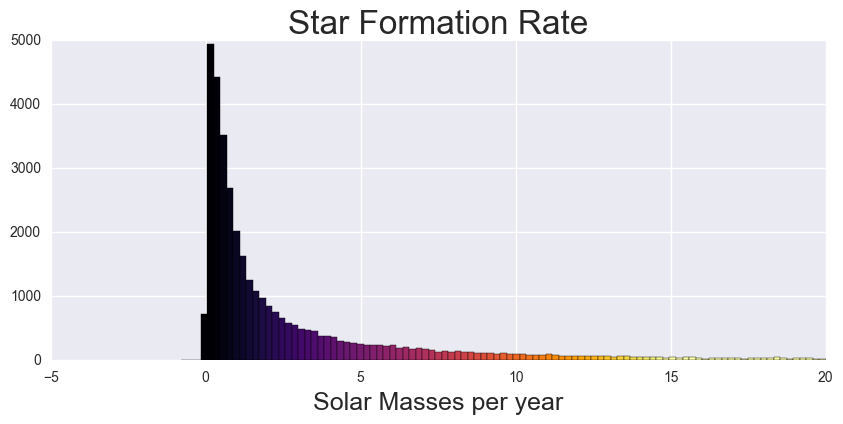

In [12]:
import matplotlib.cm as cm
import matplotlib.colors as colors
plt.figure(num=None, figsize=(10, 4), dpi=80, facecolor='w', edgecolor='k')
N, bins, patches = plt.hist(galaxyTable['SFR'],bins=100,range=[-1,20])
plt.xlabel('Solar Masses per year',fontsize=18)
plt.title('Star Formation Rate',fontsize=24)
fracs = bins.astype(float)/bins.max()
norm = colors.Normalize(0,15)

for thisbin, thispatch in zip(bins, patches):
    color = cm.inferno(norm(thisbin))
    thispatch.set_facecolor(color)

plt.savefig('data/GAMA_SFR.png', bbox_inches='tight')

In [13]:
# inferno used for Star Formation Rate
writeFile = open('data/inferno.cmap','w')
ncmap=41
writeFile.write("%d" % ncmap)
for i in range(ncmap):
  color=cm.inferno(i/(1.0*(ncmap-1.)))
  writeFile.write("%f %f %f" % (color[0],color[1],color[2]))
writeFile.close()

In [ ]:
plt.figure(num=None, figsize=(10, 4), dpi=80, facecolor='w', edgecolor='k')
N, bins, patches = plt.hist(galaxyTable['metal'],bins=100,range=[0,0.05])
plt.xlabel('Metalicity',fontsize=18)
plt.title('Metalicity',fontsize=24)
fracs = bins.astype(float)/bins.max()
norm = colors.Normalize(0.0,0.03)

for thisbin, thispatch in zip(bins, patches):
    color = cm.spring(norm(thisbin))
    thispatch.set_facecolor(color)

plt.savefig('data/Metalicity.png', bbox_inches='tight')

In [ ]:
# spring used for metalicity
writeFile = open('data/spring.cmap','w')
ncmap=21
writeFile.write("%d" % ncmap)
for i in range(ncmap):
  color=cm.spring(i/(1.0*(ncmap-1.)))
  writeFile.write("%f %f %f" % (color[0],color[1],color[2]))
writeFile.close()

##### Mark SubbaRao, Feb 22 2017